# ECG Arrhythmia Classification - Data Exploration

This notebook explores the preprocessed MIT-BIH ECG dataset to understand the structure and characteristics of the data before building classification models.

## Objectives:
1. Load and inspect the preprocessed ECG data (beat holdout and patient holdout methods)
2. Visualize class distributions and handle class imbalance through resampling
3. Examine example heartbeats from each arrhythmia class
4. Identify key ECG segments (PR interval, QRS complex, ST segment) that will be important for model explainability

## Dataset Overview:
- **Source:** MIT-BIH Arrhythmia Database
- **Classes:** 8 types of heartbeats (N, L, R, V, A, F, f, /)
- **Features:** 275 time points per heartbeat (after preprocessing and R-peak centering)
- **Two validation protocols:** Beat holdout (random split) and Patient holdout (unseen patients)

***

In [43]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
np.random.seed(42)

***

## 1. Beat Holdout Method - Data Exploration

The beat holdout method uses a random 75-25 train-test split across all patients. This data has been resampled to handle class imbalance, ensuring equal representation of all 8 arrhythmia types in the training set.

In [44]:
# Load the training data
df = pd.read_csv('train_beats.csv', header=None)

# Check the shape
print("Data shape:", df.shape)
print("First 5 rows:")
print(df.head())

Data shape: (30992, 277)
First 5 rows:
        0         1         2         3         4         5         6    \
0  2.016945  1.344029  1.344029  1.273195  1.344029  1.166946  1.060696   
1  1.956627  0.034137  0.009170  0.059105 -0.040765 -0.015798  0.034137   
2  0.435271  0.725131  0.712529  0.750337  0.788144  0.825952  0.863760   
3  0.230134 -0.199004 -0.215509 -0.215509 -0.221011 -0.221011 -0.226513   
4  3.406234 -0.103728 -0.121545 -0.050277  0.038809  0.110077  0.145711   

        7         8         9    ...       267       268       269       270  \
0  1.025279  1.025279  0.989862  ...  0.175280  0.281530  0.210697  0.175280   
1  0.084072  0.009170 -0.015798  ... -1.014493 -1.014493 -1.014493 -0.989526   
2  0.838555  0.788144  0.762939  ... -0.308283 -0.220065 -0.157051 -0.081436   
3 -0.243018 -0.254022 -0.232015  ...  1.016888  1.055400  1.071905  1.060902   
4  0.110077  0.110077  0.038809  ... -0.228447 -0.228447 -0.121545 -0.192813   

        271       272       2

In [45]:
# Separate the data
X = df.iloc[:, :-2].values  # First 275 columns = ECG signal
y = df.iloc[:, -2].values   # Second to last column = class label
patient_ids = df.iloc[:, -1].values  # Last column = patient ID

print(f"ECG signals shape: {X.shape}")
print(f"Class labels shape: {y.shape}")
print(f"Unique classes: {np.unique(y)}")
print(f"Class counts: {np.bincount(y.astype(int))[1:]}")

ECG signals shape: (30992, 275)
Class labels shape: (30992,)
Unique classes: [1. 2. 3. 4. 5. 6. 7. 8.]
Class counts: [3874 3874 3874 3874 3874 3874 3874 3874]


### Key Observations:
- Training set contains 30,992 heartbeats
- Each heartbeat has 275 time points plus 2 additional columns (class label and patient ID)
- Data has been standardized during preprocessing

***

### One-Hot Encoding:
Labels are one-hot encoded for compatibility with models (when used later). We maintain the original integer labels for visualization purposes.

**Class mapping:**
- 1: N (Normal)
- 2: L (Left Bundle Branch Block)
- 3: R (Right Bundle Branch Block)
- 4: V (Premature Ventricular Contraction)
- 5: A (Atrial Premature Beat)
- 6: F (Fusion of Ventricular and Normal)
- 7: f (Fusion of Paced and Normal)
- 8: / (Paced Beat)

In [46]:
# One-hot encode the labels
y_reshaped = y.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False, categories=[range(1, 9)])
y_onehot = encoder.fit_transform(y_reshaped)
y_original = y.copy()

print(f"Original labels shape: {y.shape}")
print(f"One-hot encoded shape: {y_onehot.shape}")
print(f"\nExample original label: {y[0]}")
print(f"Example one-hot encoded: {y_onehot[0]}")

Original labels shape: (30992,)
One-hot encoded shape: (30992, 8)

Example original label: 7.0
Example one-hot encoded: [0. 0. 0. 0. 0. 0. 1. 0.]


***

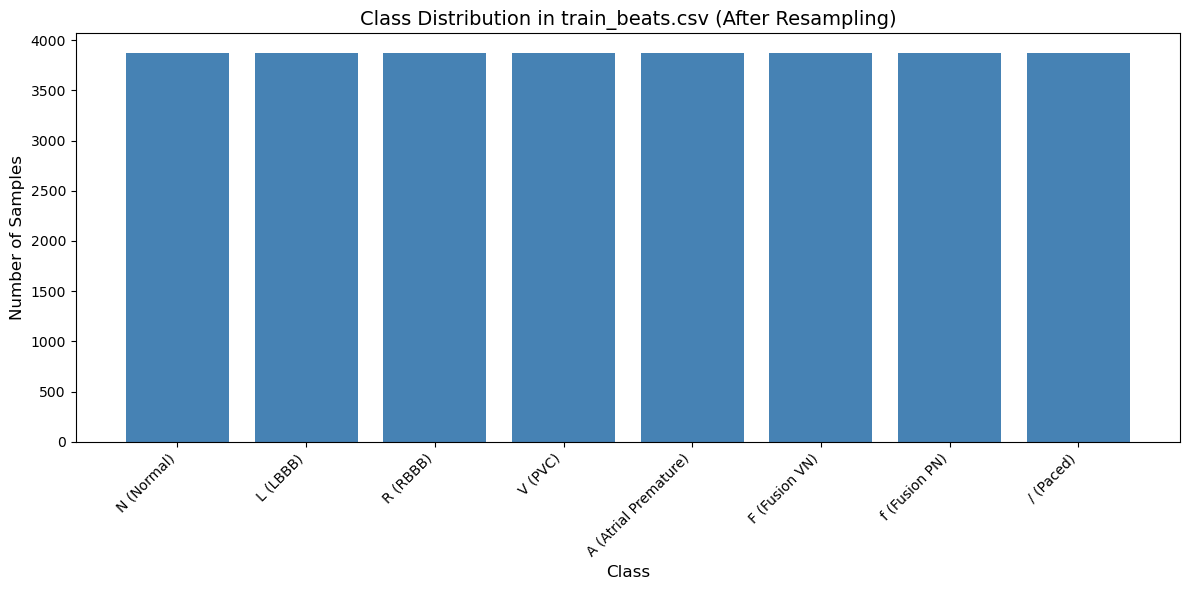

In [47]:
# Visualize class distribution
# Class names
class_names = ['N (Normal)', 
               'L (LBBB)', 
               'R (RBBB)', 
               'V (PVC)', 
               'A (Atrial Premature)', 
               'F (Fusion VN)', 
               'f (Fusion PN)', 
               '/ (Paced)']

# Count samples per class
class_counts = np.bincount(y_original.astype(int))[1:]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, 9), class_counts, color='steelblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in train_beats.csv (After Resampling)', fontsize=14)
plt.xticks(range(1, 9), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observation:
After resampling, all 8 classes are perfectly balanced with 3,874 samples each. This prevents the model from being biased toward the majority class (Normal beats).

***

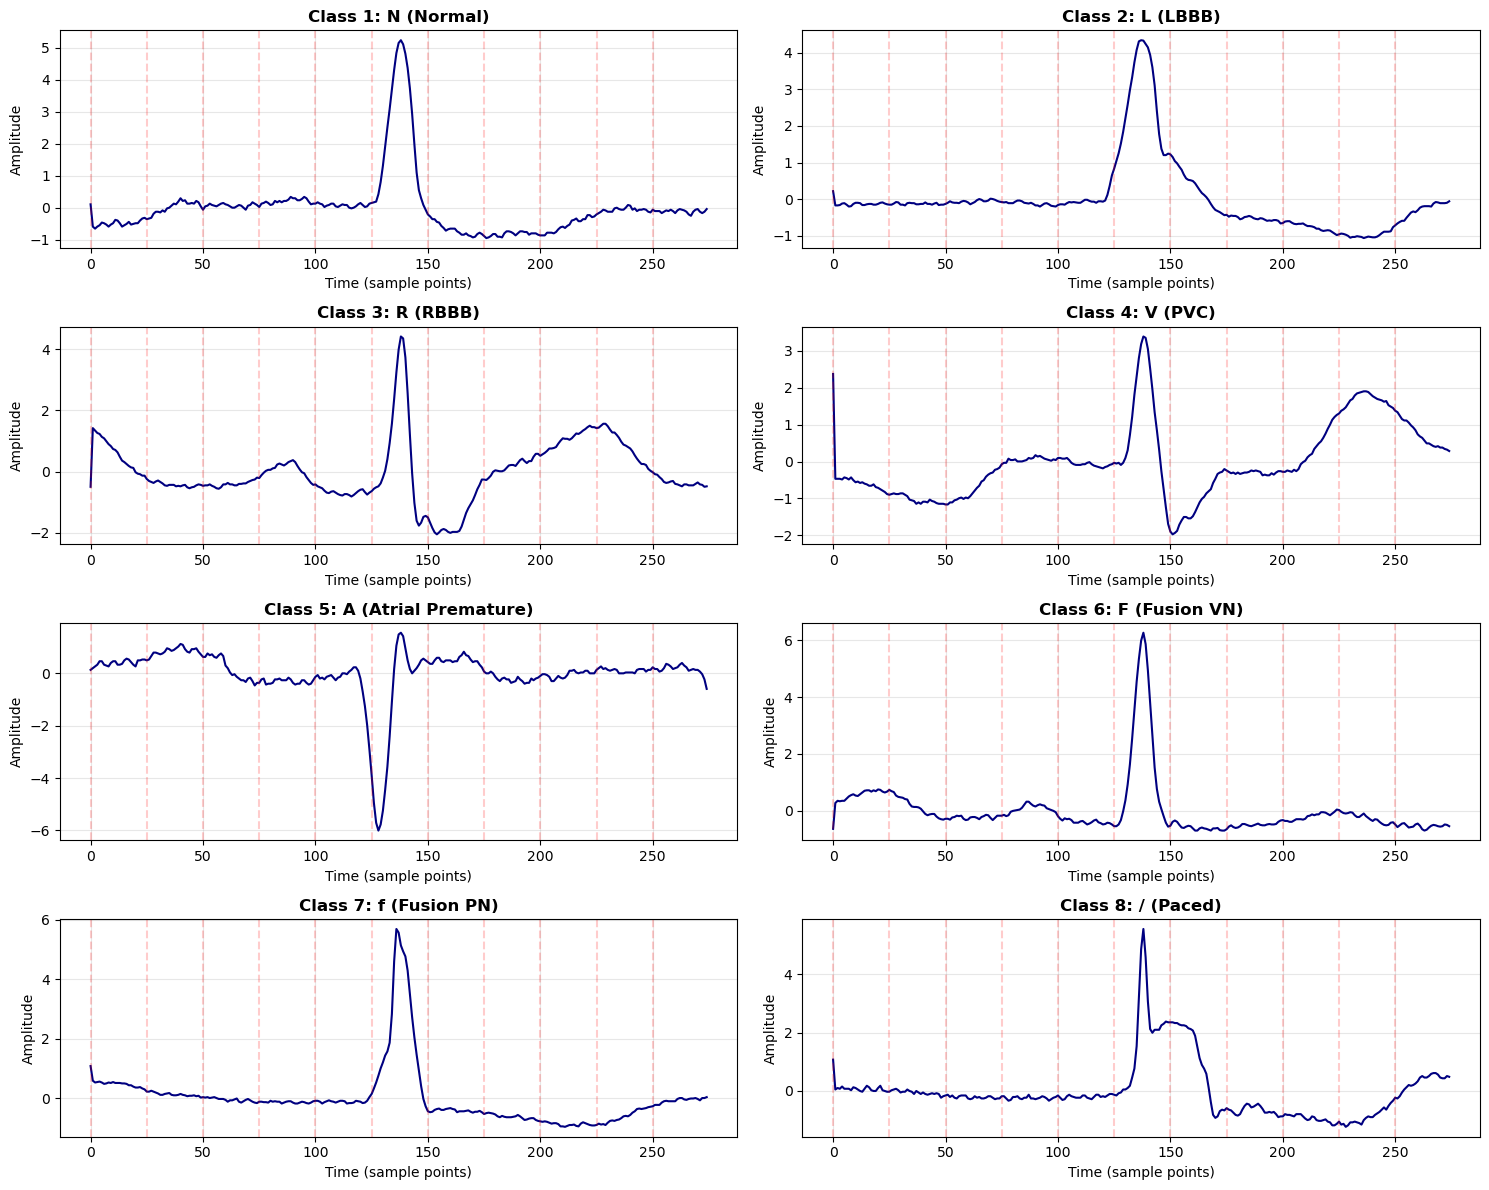

In [48]:
# Plot one example from each class
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.ravel()

for class_id in range(1, 9):
    class_indices = np.where(y_original == class_id)[0]
    idx = np.random.choice(class_indices)
    sample = X[idx]
    
    # Plot
    axes[class_id - 1].plot(sample, linewidth=1.5, color='navy')
    axes[class_id - 1].set_title(f'Class {class_id}: {class_names[class_id - 1]}', 
                                  fontsize=12, fontweight='bold')
    axes[class_id - 1].set_xlabel('Time (sample points)')
    axes[class_id - 1].set_ylabel('Amplitude')
    axes[class_id - 1].grid(alpha=0.3)
    
    for seg in range(0, 275, 25):
        axes[class_id - 1].axvline(seg, color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

### Observations:
- **Normal (N):** Clear P-wave, narrow QRS complex, normal T-wave
- **LBBB (L) & RBBBB (R):** Wider or more irregular QRS complexes
- **PVC (V):** Premature beat with abnormal QRS morphology
- **Atrial Premature (A):** Noticeably inverted QRS complex
- **Paced (/):** Artificial spike from pacemaker followed by altered QRS

These visual differences suggest that the QRS complex region (segments 5-7) will likely be the most important feature for classification.

***

### Cross-class beat samples

One random beat from each class is displayed to illustrate the characteristic morphological differences across arrhythmias, with particular attention to changes in the PR interval, QRS complex, and ST segment.

### ECG Segment Annotations:
- **PR Interval (segments 1-4, blue):** Atrial depolarization
- **QRS Complex (segments 5-7, red):** Ventricular depolarization - typically the most diagnostically important
- **ST Segment (segments 8-11, green):** Ventricular repolarization


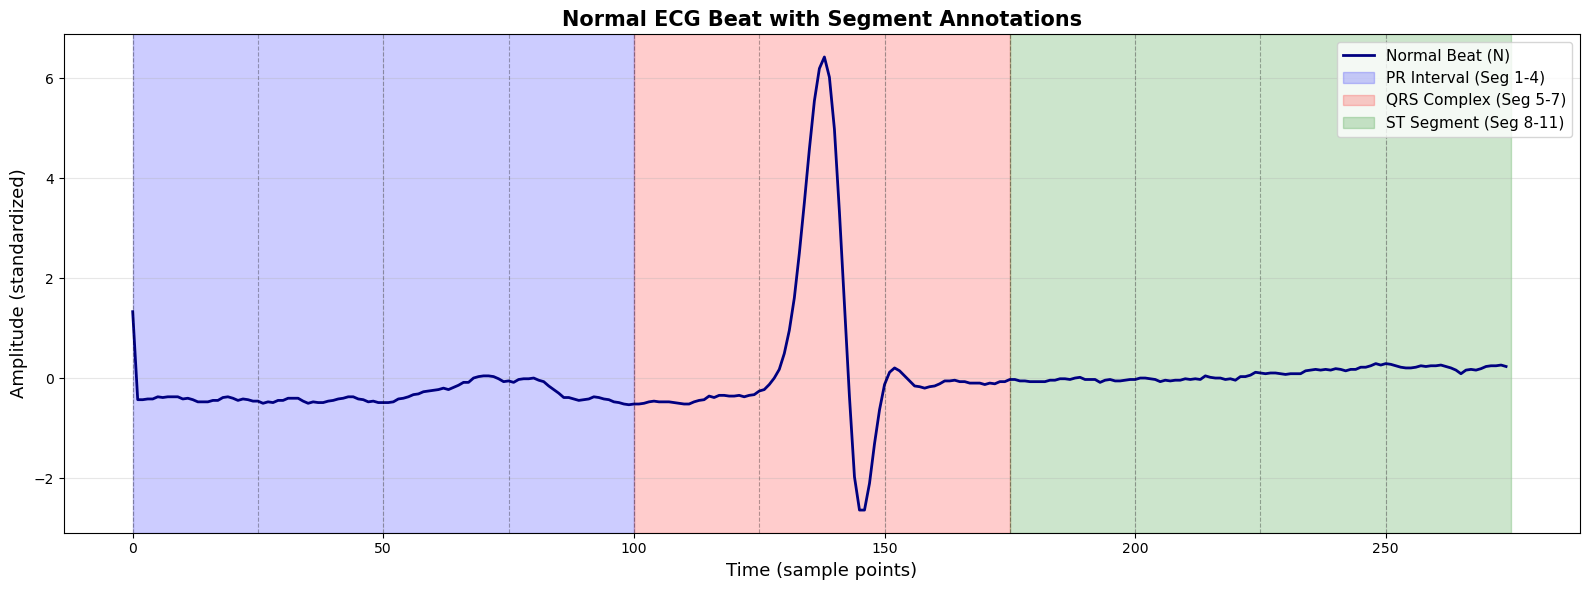

In [49]:
# Plot a Normal beat with segment annotations
fig, ax = plt.subplots(figsize=(16, 6))

# Get a random 'N' beat (class 1)
normal_indices = np.where(y_original == 1)[0]
random_idx = np.random.choice(normal_indices)
normal_beat = X[random_idx]

ax.plot(normal_beat, linewidth=2, color='navy', label='Normal Beat (N)')

# Define segment regions
ax.axvspan(0, 100, alpha=0.2, color='blue', label='PR Interval (Seg 1-4)')
ax.axvspan(100, 175, alpha=0.2, color='red', label='QRS Complex (Seg 5-7)')
ax.axvspan(175, 275, alpha=0.2, color='green', label='ST Segment (Seg 8-11)')

# Add segment dividers
for seg in range(0, 275, 25):
    ax.axvline(seg, color='black', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Time (sample points)', fontsize=13)
ax.set_ylabel('Amplitude (standardized)', fontsize=13)
ax.set_title('Normal ECG Beat with Segment Annotations', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

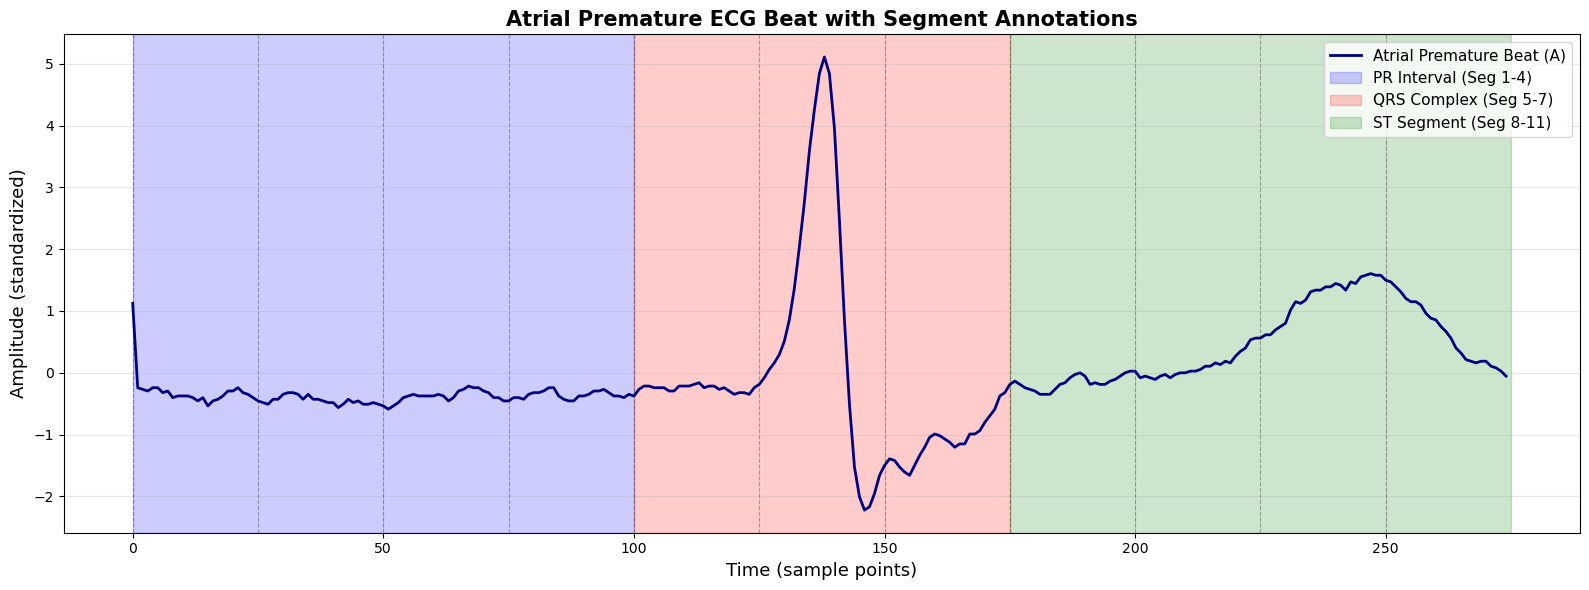

In [50]:
# Plot an Atrial Premature beat with segment annotations
fig, ax = plt.subplots(figsize=(16, 6))

# Get a random 'A' beat (class 5)
atrial_premature_indices = np.where(y_original == 5)[0]
random_idx = np.random.choice(atrial_premature_indices)
atrial_premature_beat = X[random_idx]

ax.plot(atrial_premature_beat, linewidth=2, color='navy', label='Atrial Premature Beat (A)')

# Define segment regions
ax.axvspan(0, 100, alpha=0.2, color='blue', label='PR Interval (Seg 1-4)')
ax.axvspan(100, 175, alpha=0.2, color='red', label='QRS Complex (Seg 5-7)')
ax.axvspan(175, 275, alpha=0.2, color='green', label='ST Segment (Seg 8-11)')

# Add segment dividers
for seg in range(0, 275, 25):
    ax.axvline(seg, color='black', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Time (sample points)', fontsize=13)
ax.set_ylabel('Amplitude (standardized)', fontsize=13)
ax.set_title('Atrial Premature ECG Beat with Segment Annotations', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

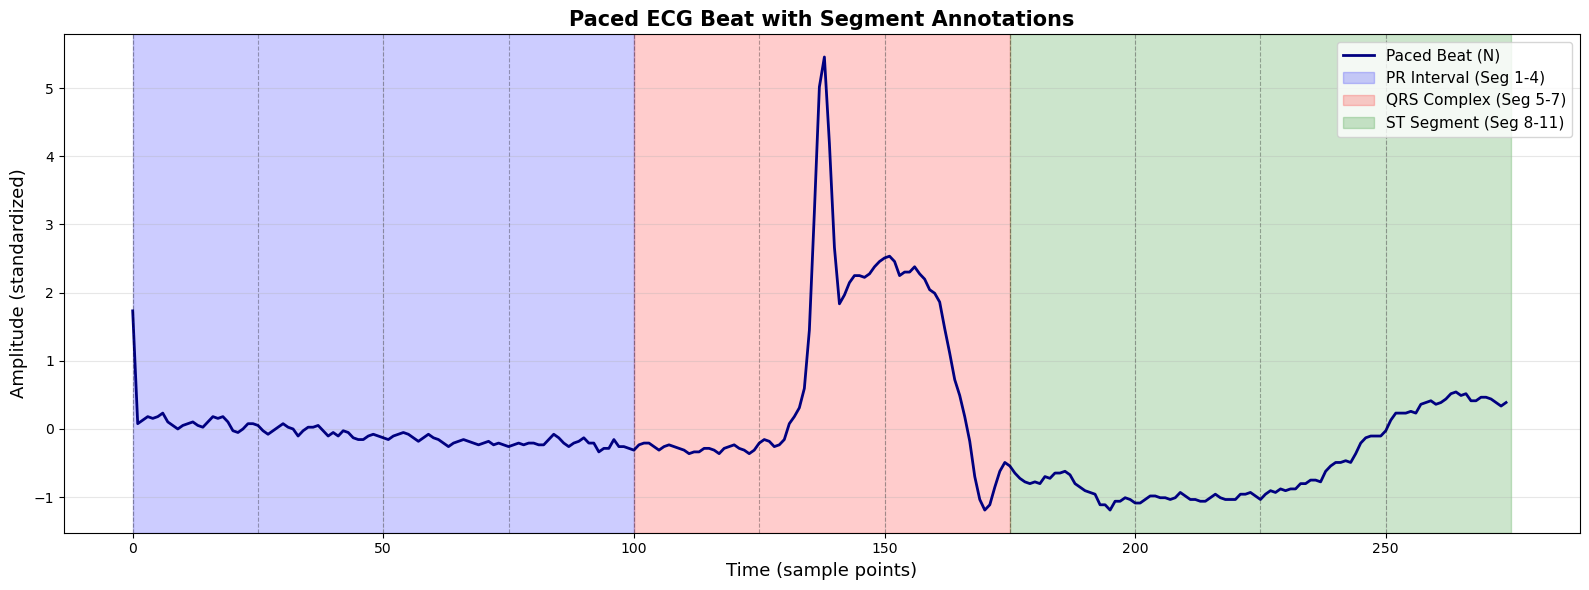

In [51]:
# Plot a Paced beat with segment annotations
fig, ax = plt.subplots(figsize=(16, 6))

# Get a random '/' beat (class 8)
paced_indices = np.where(y_original == 8)[0]
random_idx = np.random.choice(paced_indices)
paced_beat = X[random_idx]

ax.plot(paced_beat, linewidth=2, color='navy', label='Paced Beat (N)')

# Define segment regions
ax.axvspan(0, 100, alpha=0.2, color='blue', label='PR Interval (Seg 1-4)')
ax.axvspan(100, 175, alpha=0.2, color='red', label='QRS Complex (Seg 5-7)')
ax.axvspan(175, 275, alpha=0.2, color='green', label='ST Segment (Seg 8-11)')

# Add segment dividers
for seg in range(0, 275, 25):
    ax.axvline(seg, color='black', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Time (sample points)', fontsize=13)
ax.set_ylabel('Amplitude (standardized)', fontsize=13)
ax.set_title('Paced ECG Beat with Segment Annotations', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

***

## 2. Patient Holdout Method - Data Exploration

The patient holdout method holds out 5 specific patients (104, 113, 119, 208, 210) for testing. This is a more realistic evaluation as it tests the model's ability to generalize to completely unseen patients.

In [52]:
# Load the patient holdout training data
df_patients = pd.read_csv('train_patients.csv', header=None)

print("Data shape:", df_patients.shape)

Data shape: (200352, 277)


In [53]:
# Separate the data
X_patients = df_patients.iloc[:, :-2].values  
y_patients = df_patients.iloc[:, -2].values   
patient_ids_patients = df_patients.iloc[:, -1].values

print(f"ECG signals shape: {X_patients.shape}")
print(f"Class labels shape: {y_patients.shape}")
print(f"Unique classes: {np.unique(y_patients)}")
print(f"Class counts: {np.bincount(y_patients.astype(int))[1:]}")

ECG signals shape: (200352, 275)
Class labels shape: (200352,)
Unique classes: [1. 2. 3. 4. 5. 6. 7. 8.]
Class counts: [25044 25044 25044 25044 25044 25044 25044 25044]


### Observation:
Despite using patient holdout, all 8 classes remain balanced at 25,044 samples each after resampling. This larger training set (200,352 vs 30,992) is due to using data from more patients in the training phase.

***

In [54]:
# One-hot encode the labels
y_patients_reshaped = y_patients.reshape(-1, 1)
y_patients_onehot = encoder.transform(y_patients_reshaped)  # Use same encoder
y_patients_original = y_patients.copy()

print(f"Original labels shape: {y_patients.shape}")
print(f"One-hot encoded shape: {y_patients_onehot.shape}")
print(f"\nExample original label: {y_patients[0]}")
print(f"Example one-hot encoded: {y_patients_onehot[0]}")

Original labels shape: (200352,)
One-hot encoded shape: (200352, 8)

Example original label: 7.0
Example one-hot encoded: [0. 0. 0. 0. 0. 0. 1. 0.]


### Patient-holdout visualisation

The same visualisation steps are repeated under the patient-holdout setting. First, class distribution is visualised, then eight patients are sampled to show the overall distribution of beats across individuals. This is followed by detailed visualisation of individual cases.


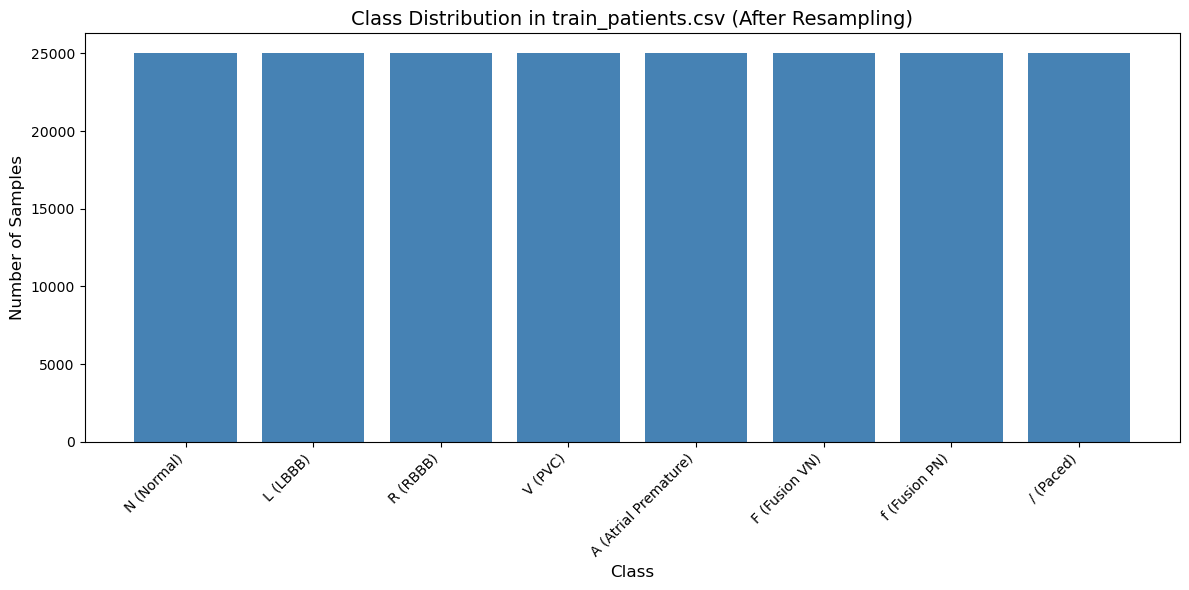

In [55]:
# Class names
class_names = ['N (Normal)', 
               'L (LBBB)', 
               'R (RBBB)', 
               'V (PVC)', 
               'A (Atrial Premature)', 
               'F (Fusion VN)', 
               'f (Fusion PN)', 
               '/ (Paced)']

# Count samples per class
class_counts = np.bincount(y_patients.astype(int))[1:]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, 9), class_counts, color='steelblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in train_patients.csv (After Resampling)', fontsize=14)
plt.xticks(range(1, 9), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

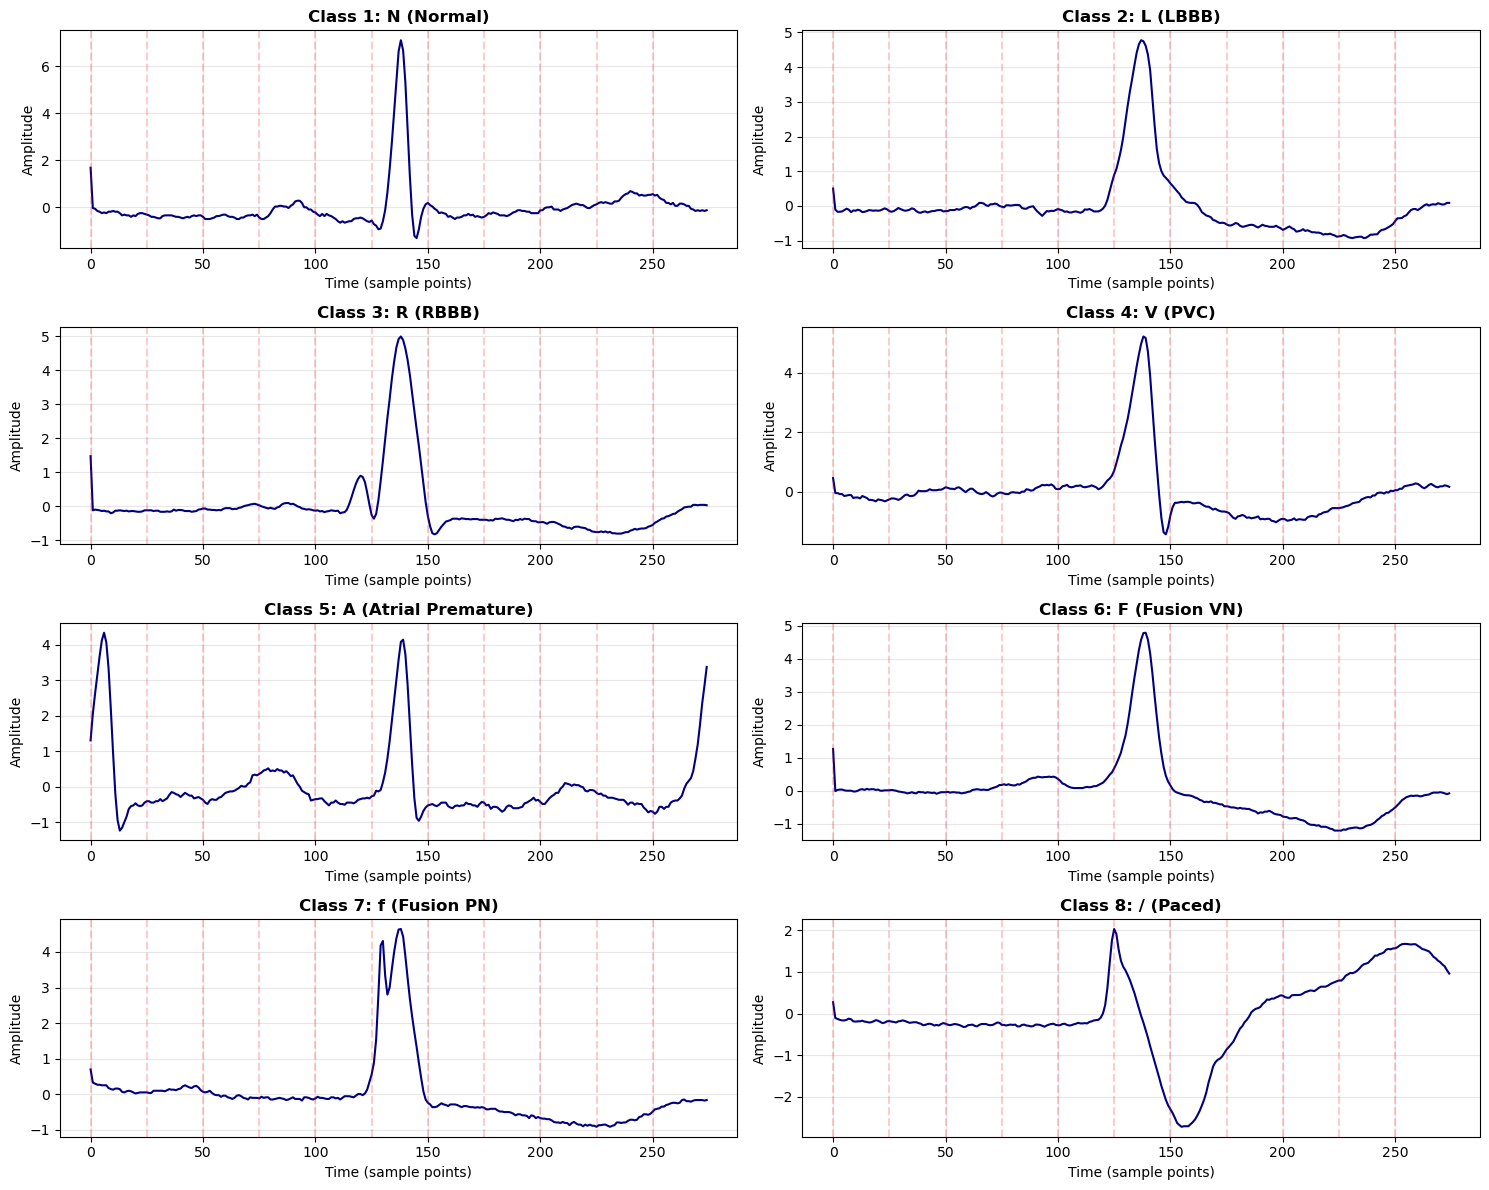

In [56]:
# Plot one example from each class
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.ravel()

for class_id in range(1, 9):
    class_indices = np.where(y_original == class_id)[0]
    idx = np.random.choice(class_indices)
    sample = X[idx]
    
    # Plot
    axes[class_id - 1].plot(sample, linewidth=1.5, color='navy')
    axes[class_id - 1].set_title(f'Class {class_id}: {class_names[class_id - 1]}', 
                                  fontsize=12, fontweight='bold')
    axes[class_id - 1].set_xlabel('Time (sample points)')
    axes[class_id - 1].set_ylabel('Amplitude')
    axes[class_id - 1].grid(alpha=0.3)
    
    for seg in range(0, 275, 25):
        axes[class_id - 1].axvline(seg, color='red', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

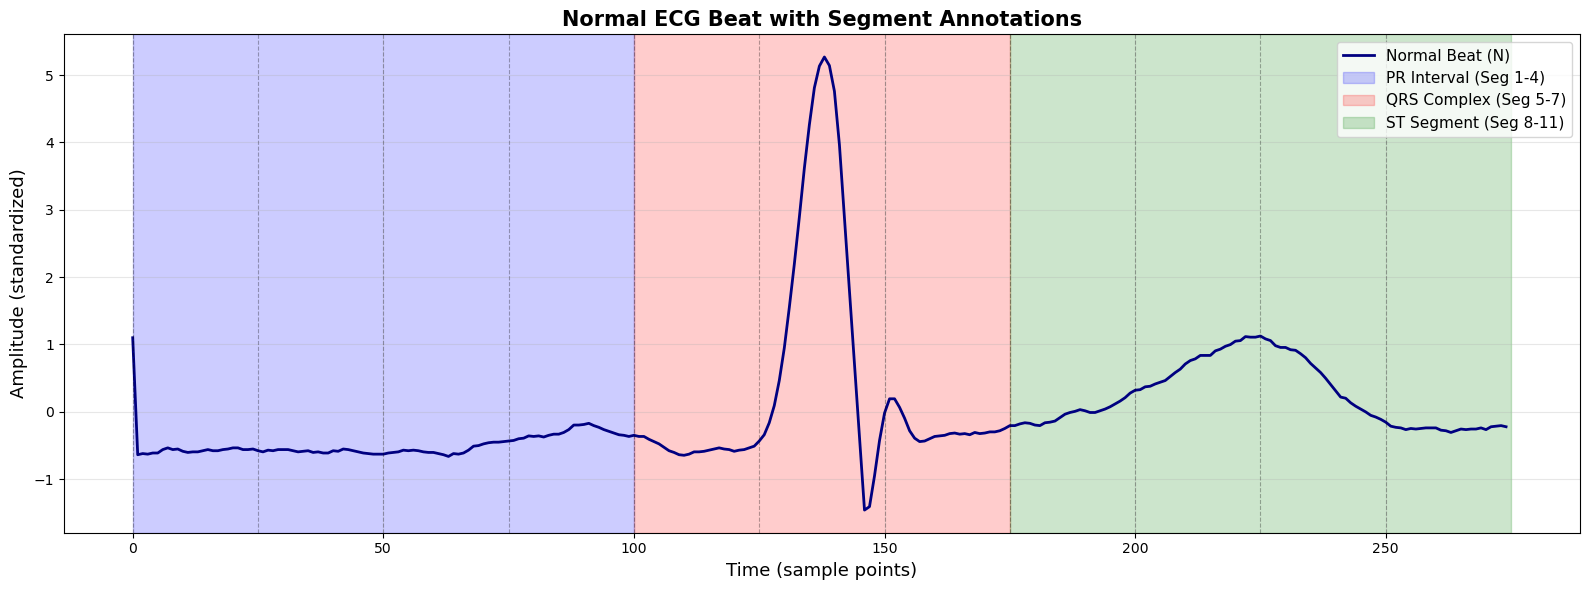

In [57]:
# Plot a Normal beat with segment annotations
fig, ax = plt.subplots(figsize=(16, 6))

# Get a random 'N' beat (class 1)
normal_indices = np.where(y_patients == 1)[0]
random_idx = np.random.choice(normal_indices)
normal_beat = X_patients[random_idx]

ax.plot(normal_beat, linewidth=2, color='navy', label='Normal Beat (N)')

# Define segment regions
ax.axvspan(0, 100, alpha=0.2, color='blue', label='PR Interval (Seg 1-4)')
ax.axvspan(100, 175, alpha=0.2, color='red', label='QRS Complex (Seg 5-7)')
ax.axvspan(175, 275, alpha=0.2, color='green', label='ST Segment (Seg 8-11)')

# Add segment dividers
for seg in range(0, 275, 25):
    ax.axvline(seg, color='black', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Time (sample points)', fontsize=13)
ax.set_ylabel('Amplitude (standardized)', fontsize=13)
ax.set_title('Normal ECG Beat with Segment Annotations', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

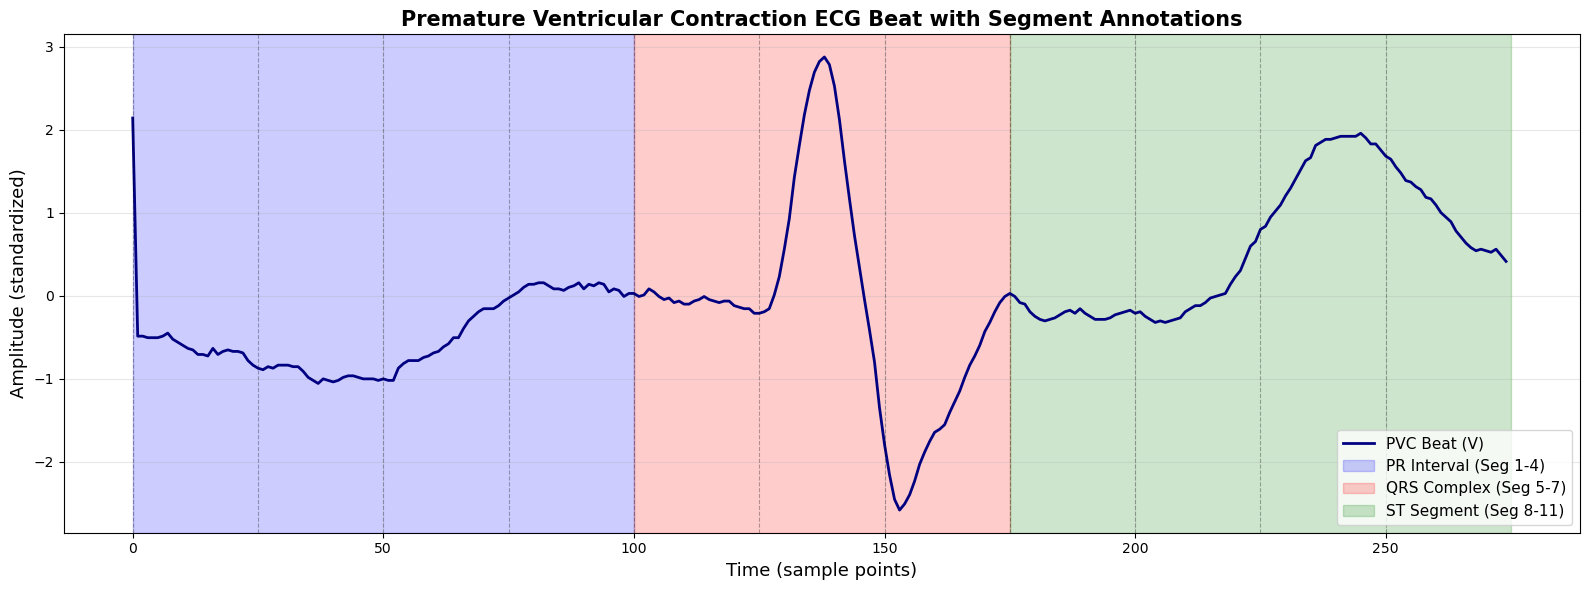

In [58]:
# Plot a Premature Ventricular Contraction beat with segment annotations
fig, ax = plt.subplots(figsize=(16, 6))

# Get a random 'V' beat (class 4)
premature_ventricular_contraction_indices = np.where(y_patients == 4)[0]
random_idx = np.random.choice(premature_ventricular_contraction_indices)
premature_ventricular_contraction_beat = X_patients[random_idx]

ax.plot(premature_ventricular_contraction_beat, linewidth=2, color='navy', label='PVC Beat (V)')

# Define segment regions
ax.axvspan(0, 100, alpha=0.2, color='blue', label='PR Interval (Seg 1-4)')
ax.axvspan(100, 175, alpha=0.2, color='red', label='QRS Complex (Seg 5-7)')
ax.axvspan(175, 275, alpha=0.2, color='green', label='ST Segment (Seg 8-11)')

# Add segment dividers
for seg in range(0, 275, 25):
    ax.axvline(seg, color='black', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Time (sample points)', fontsize=13)
ax.set_ylabel('Amplitude (standardized)', fontsize=13)
ax.set_title('Premature Ventricular Contraction ECG Beat with Segment Annotations', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

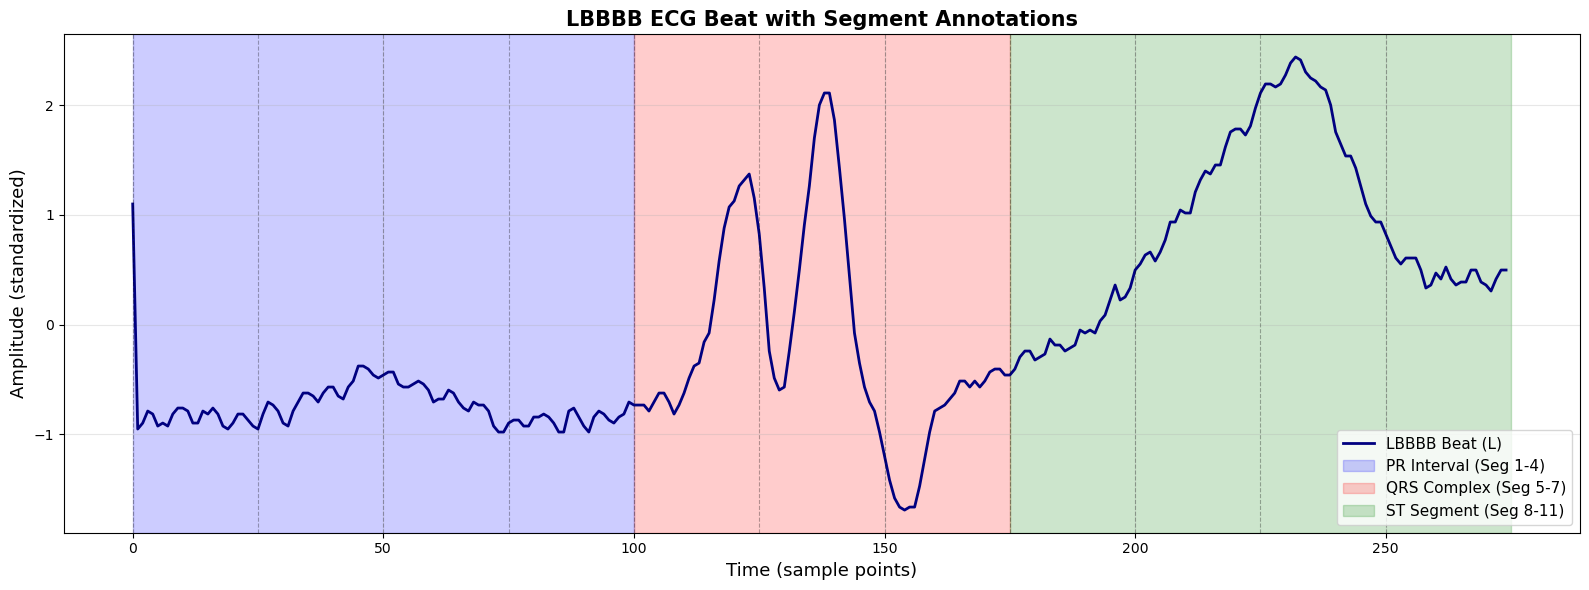

In [59]:
# Plot a LBBBB beat with segment annotations
fig, ax = plt.subplots(figsize=(16, 6))

# Get a random 'L' beat (class 2)
lbbbb_indices = np.where(y_patients == 2)[0]
random_idx = np.random.choice(lbbbb_indices)
lbbbb_beat = X_patients[random_idx]

ax.plot(lbbbb_beat, linewidth=2, color='navy', label='LBBBB Beat (L)')

# Define segment regions
ax.axvspan(0, 100, alpha=0.2, color='blue', label='PR Interval (Seg 1-4)')
ax.axvspan(100, 175, alpha=0.2, color='red', label='QRS Complex (Seg 5-7)')
ax.axvspan(175, 275, alpha=0.2, color='green', label='ST Segment (Seg 8-11)')

# Add segment dividers
for seg in range(0, 275, 25):
    ax.axvline(seg, color='black', linestyle='--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Time (sample points)', fontsize=13)
ax.set_ylabel('Amplitude (standardized)', fontsize=13)
ax.set_title('LBBBB ECG Beat with Segment Annotations', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

**Key Findings:**
1. Both datasets are successfully balanced after resampling
2. Visual inspection confirms distinct morphological differences between arrhythmia types
3. QRS complex appears to be the most variable region across classes
4. Patient holdout provides a larger training set but tests on more challenging unseen patients

**Next Steps:**
- Build and train classifiers on both datasets
- Apply explainability methods to understand model decisions
- Compare performance between beat holdout and patient holdout methods